In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
os.environ['USE_PYGEOS'] = '0'

import rasterio
from rasterio.plot import show
from rasterio.mask import mask
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import pyproj, folium, torch
import numpy as np
import networkx as nx
import contextily as cx
from IPython.display import display
from scipy import stats
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_curve, auc
from torch_geometric.utils import from_networkx
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

%matplotlib notebook

# Import UN profiled data and HOTOSM data, extract relevant satellite data

# Preparing data to be input to supervised GNN

In [2]:
def step_load_data():
    '''
    return: profiled buildings with added satellite data
            unprofiled buildings with added satellite data
            red-flagged buildings
    '''
    
    # check if processed data exists in file, otherwise load raw data and process
    if os.path.exists('Data/Supervised_GNN/profiled_buildings_with_satellite_data.gpkg'):
        profiled_buildings_with_satellite_data = gpd.read_file('Data/Supervised_GNN/profiled_buildings_with_satellite_data.gpkg', driver='GPKG')
        unprofiled_buildings_with_satellite_data = gpd.read_file('Data/Supervised_GNN/unprofiled_buildings_with_satellite_data.gpkg', driver='GPKG')
        redflag_buildings = gpd.read_file('Data/Supervised_GNN/profiled_redflag_buildings', driver='GPKG')
    else:
        # import UN profiled data and HOTOSM data
        profiled_buildings, profiled_limits, profiled_redflag_buildings = load_profiled_data()
        unprofiled_buildings, unprofiled_streets = load_unprofiled_data(profiled_buildings)

        profiled_buildings.to_file('Data/Supervised_GNN/profiled_buildings', driver='GPKG')
        profiled_limits.to_file('Data/Supervised_GNN/profiled_limits', driver='GPKG')
        profiled_redflag_buildings.to_file('Data/Supervised_GNN/profiled_redflag_buildings', driver='GPKG')
        unprofiled_buildings.to_file('Data/Supervised_GNN/unprofiled_buildings', driver='GPKG')
        unprofiled_streets.to_file('Data/Supervised_GNN/unprofiled_streets', driver='GPKG')

        # extract relevant satellite data
        profiled_buildings_with_satellite_data, unprofiled_buildings_with_satellite_data = extract_satellite_data_to_gdf(profiled_buildings, unprofiled_buildings)
        redflag_buildings = profiled_redflag_buildings
        
        profiled_buildings_with_satellite_data.to_file('Data/Supervised_GNN/profiled_buildings_with_satellite_data', driver='GPKG')
        profiled_buildings_with_satellite_data.to_file('Data/Supervised_GNN/unprofiled_buildings_with_satellite_data', driver='GPKG')
    
    return profiled_buildings_with_satellite_data, unprofiled_buildings_with_satellite_data, redflag_buildings
    
def load_profiled_data():
    alldata_buildings = gpd.read_file('Data/UN_Profiled_Data/TripoliNBHs_AllData_Buildings.dbf')
    limits = gpd.read_file('Data/UN_Profiled_Data/TripoliNBHs_Limits.dbf')
    redflag_buildings = gpd.read_file('Data/UN_Profiled_Data/TripoliNBHs_RedFlagBuilidngs.dbf')
    
    # reproject to same crs
    profiled_buildings = alldata_buildings.copy()
    limits_reproj = limits.to_crs(alldata_buildings.crs)
    redflag_buildings_reproj = redflag_buildings.to_crs(alldata_buildings.crs)

    return profiled_buildings, limits_reproj, redflag_buildings_reproj

def load_unprofiled_data(profiled_buildings):
    unprofiled_buildings = gpd.read_file('Data/Unsupervised_GNN/1d_buildings_Tripoli.gpkg', driver='GPKG')
    unprofiled_buildings_reproj = unprofiled_buildings.to_crs(profiled_buildings.crs)
    
    unprofiled_streets = gpd.read_file('Data/Unsupervised_GNN/1e_streets_Tripoli.gpkg', driver='GPKG')
    unprofiled_streets_reproj = unprofiled_streets.to_crs(profiled_buildings.crs)
    
    return unprofiled_buildings_reproj, unprofiled_streets_reproj

def extract_satellite_data_to_gdf(profiled_buildings, unprofiled_buildings):
    # for profiled buildings, use satellite data collected before profiling is conducted
    satellite_data_before_profiling = extract_satellite_data(profiled_buildings, before_profiling=True)
    profiled_buildings_with_satellite_data = append_satellite_data_to_gdf(profiled_buildings, satellite_data_before_profiling)
    
    # for unprofiled buildings, use up-to-date satellite data
    satellite_data_after_profiling = extract_satellite_data(unprofiled_buildings, before_profiling=False)
    unprofiled_buildings_with_satellite_data = append_satellite_data_to_gdf(unprofiled_buildings, satellite_data_after_profiling)
    
    return profiled_buildings_with_satellite_data, unprofiled_buildings_with_satellite_data
    

def extract_satellite_data(gdf, before_profiling=True):
    # specify paths to satellite data
    paths_before_profiling = ['Data/Satellite_Data/20170421_R10m/L2A_T37SBU_20170421T082011_AOT_10m.jp2',
             'Data/Satellite_Data/20170421_R10m/L2A_T37SBU_20170421T082011_B02_10m.jp2',
             'Data/Satellite_Data/20170421_R10m/L2A_T37SBU_20170421T082011_B03_10m.jp2',
             'Data/Satellite_Data/20170421_R10m/L2A_T37SBU_20170421T082011_B04_10m.jp2',
             'Data/Satellite_Data/20170421_R10m/L2A_T37SBU_20170421T082011_B08_10m.jp2',
             'Data/Satellite_Data/20170421_R10m/L2A_T37SBU_20170421T082011_TCI_10m.jp2',
             'Data/Satellite_Data/20170421_R10m/L2A_T37SBU_20170421T082011_WVP_10m.jp2']
    
    paths_after_profiling = ['Data/Satellite_Data/20231201_R10m/T37SBU_20231201T082219_AOT_10m.jp2',
             'Data/Satellite_Data/20231201_R10m/T37SBU_20231201T082219_B02_10m.jp2',
             'Data/Satellite_Data/20231201_R10m/T37SBU_20231201T082219_B03_10m.jp2',
             'Data/Satellite_Data/20231201_R10m/T37SBU_20231201T082219_B04_10m.jp2',
             'Data/Satellite_Data/20231201_R10m/T37SBU_20231201T082219_B08_10m.jp2',
             'Data/Satellite_Data/20231201_R10m/T37SBU_20231201T082219_TCI_10m.jp2',
             'Data/Satellite_Data/20231201_R10m/T37SBU_20231201T082219_WVP_10m.jp2']
    
    # select desired satellite data
    if before_profiling == True:
        paths = paths_before_profiling
    elif before_profiling == False:
        paths = paths_after_profiling

    # list of columns to be used as dictionary keys
    columns = ['AOT', 'B02', 'B03', 'B04', 'B08', 'TCI', 'WVP']
    satellite_data_statistics = {}

    # iterate through each satellite data
    for path, column in zip(paths, columns):
        statistics = {}
        mean_list = []
        var_list = []
        with rasterio.open(path) as src:
            # ensure building geometry share same crs as satellite data
            gdf_reproj = gdf.to_crs(src.crs)
        
            #iterate through each building to use geoemtry polygon as mask
            for index, row in gdf_reproj.iterrows():

                # create bounding box polygon
                bbox_gdf = gpd.GeoDataFrame(geometry=[row['geometry']])

                # mask selected portion 
                masked_data, _ = mask(src, bbox_gdf.geometry, all_touched=True, crop=True) # all_touched for small buildings

                # filter out zeroes and nan values when computing data satistics
                non_zero_data = masked_data.astype(float)
                non_zero_data[non_zero_data == 0] = np.nan

                mean_value = np.nanmean(non_zero_data, axis=(1,2))
                var_value = np.nanvar(non_zero_data, axis=(1,2))

                # add statistics for each building to list
                mean_list.append(mean_value)
                var_list.append(var_value)

        # add statistics for each satellite data to dictionary
        statistics['mean'] = mean_list
        statistics['variance'] = var_list

        satellite_data_statistics[column] = statistics
        
    return satellite_data_statistics

def append_satellite_data_to_gdf(gdf, satellite_data_statistics):
    gdf_with_satellite_data = gdf.copy()

    # append extracted mean satellite data for each building polygon as new column in gdf
    for key, data in satellite_data_statistics.items():
        if data['mean'][0].shape[0] == 1:
            gdf_with_satellite_data[f'{key}_mean'] = [i[0] for i in data['mean']]
            gdf_with_satellite_data[f'{key}_var'] = [i[0] for i in data['variance']]
        else:
            stacked_mean = np.vstack([i for i in data['mean']])
            stacked_var = np.vstack([i for i in data['variance']])
            for i in range(stacked_mean.shape[1]):
                gdf_with_satellite_data[f'{key}_mean_{i+1}'] = stacked_mean[:,i]
                gdf_with_satellite_data[f'{key}_var_{i+1}'] = stacked_var[:,i]
    
    return gdf_with_satellite_data

In [3]:
def step_process_input_data(profiled_buildings, red_flagged_buildings):
    '''
    input: profiled buildings
           red-flagged buildings
    return: profiled buildings with labels and processed attributes ready to be input to GNN    
    '''
    buildings = profiled_buildings.copy()
    buildings_with_red_flag = add_red_flagged_column(buildings, red_flagged_buildings)
    buildings_with_modified_columns = add_and_drop_columns(buildings_with_red_flag)
    buildings_with_mapping = data_mapping(buildings_with_modified_columns)

    return buildings_with_mapping
    
def add_red_flagged_column(buildings, red_flagged_buildings):
    # identify red-flag buildings via buffer red-flag buildings inwards and use intersection
    buildings['red_flag'] = 0
    buffered_red_flagged = red_flagged_buildings.buffer(-1).unary_union
    buildings.loc[buildings['geometry'].intersects(buffered_red_flagged), 'red_flag']=1
    
    return buildings
    
def add_and_drop_columns(buildings):
    # add relevant columns
    buildings['Area'] = buildings['geometry'].area
    buildings['Length'] = buildings['geometry'].length
    
    # drop unwanted columns
    buildings = buildings.drop(columns=['NBH_Name_1', 'District_1', 'Governor_1', 'ACS_Code_1', 'P_Code', 'Habitat_Co', 'ACS_Name_1', 
                        'OBJECTID_1', 'geometry', 'Year_1', 'Electricit', 'Shape_Le_1', ## duplicate entries
                        'WasteWater', 'StormWater', 'DomesticWa', 'Structural', 'Exterior', 'Communal',
                                       'Shape_Leng', 'Shape_Area'])
    
    return buildings

def data_mapping(buildings):
    # one-hot encoding for certain categories in column Use_
    categories_to_one_hot = ['Commercial', 'Mixed-use', 'Residential', 'Social', 'Military', 'Governmental']
    for category in categories_to_one_hot:
        buildings[f'Use_{category}'] = (buildings['Use_'] == category).astype(int)

    buildings.drop(columns=['Use_'], inplace=True) 

    # define mapping for 'Age' values
    age_mapping = {
        'Pre-1920': 1,
        '1920-1943': 2,
        '1944-1975': 3,
        '1976-2000': 4,
        'Post-2000': 5,
        'post2000': 5  }

    # apply mapping to 'Age' column
    buildings['Age'] = buildings['Age'].map(age_mapping)

    # replace various representations of missing values with NaN
    missing_values = ['No data', '<Null>']
    buildings.replace(missing_values, np.nan, inplace=True)
    # fill with 0 to avoid affecting similarity caluclations?
    buildings = buildings.fillna(0)
    
    return buildings

# Split data into subsets

In [4]:
def step_data_splitting(x_processed):  
    '''
    split data into subsets for ensemble training
    
    input: input dataset for GNN
    return: train datasets
            test datasets
            validation datasets
    '''
    x_processed = x_processed.apply(pd.to_numeric)
    
    # split into train, test, validation sets
    train_set, test_set, validation_set = split_train_test_validate_data(x_processed, flagged_fraction=0.5, train_ratio=0.7, test_ratio=0.15, val_ratio=0.15)
    
    # further split train, validation sets for each model
    train_subsets = sample_subset(train_set, 100, 10)
    validation_subsets = sample_subset(validation_set, 30, 10)
    test_subsets = sample_subset(test_set, 50, 10)
    
    return train_subsets, validation_subsets, test_subsets

def split_train_test_validate_data(X, flagged_fraction, train_ratio=0.8, val_ratio=0.15, test_ratio=0.15, random_state=42):
    X_red_flagged = X[X['red_flag'] == 1]
    X_unflagged = X[X['red_flag'] == 0]
    
    # check flagged fraction is valid
    if 0.14 < flagged_fraction < 1:
        unflagged_sample_size = int(X_red_flagged.shape[0] * (1-flagged_fraction) / flagged_fraction)
        unflagged_samples = X_unflagged.sample(unflagged_sample_size, random_state=random_state)
        
        # split dataset into train, test, and validate sets
        train_flagged_data, test_flagged_data = train_test_split(X_red_flagged, test_size=(test_ratio+val_ratio), random_state=random_state)
        validate_flagged_data, test_flagged_data = train_test_split(test_flagged_data, test_size=test_ratio / (test_ratio + val_ratio), random_state=random_state)

        train_unflagged_data, test_unflagged_data = train_test_split(unflagged_samples, test_size=(test_ratio+val_ratio), random_state=random_state)
        validate_unflagged_data, test_unflagged_data = train_test_split(test_unflagged_data, test_size=test_ratio / (test_ratio + val_ratio), random_state=random_state)
        
        # combine flagged and unflagged buildings for train, test, and validation sets
        train_set = gpd.GeoDataFrame(pd.concat([train_flagged_data, train_unflagged_data]))
        test_set = gpd.GeoDataFrame(pd.concat([test_flagged_data, test_unflagged_data]))
        validation_set = gpd.GeoDataFrame(pd.concat([validate_flagged_data, validate_unflagged_data]))
        
        return train_set, test_set, validation_set

def sample_subset(X, sample_size, subset_size):
    red_flagged_indices = X.index[X['red_flag'] == 1].values
    unflagged_indices = X.index[X['red_flag'] == 0].values
    np.random.seed(123456)
    
    subset_list = []
    
    for i in range(subset_size):
        # shuffle the flagged and unflagged indices
        np.random.shuffle(red_flagged_indices)
        np.random.shuffle(unflagged_indices)
        
        # randomly sample flagged and unflagged indices without overlaps
        sampled_flagged_indices = np.random.choice(red_flagged_indices, size=int(sample_size/2), replace=False)
        sampled_unflagged_indices = np.random.choice(unflagged_indices, size=int(sample_size/2), replace=False)

        # combine flagged and unflagged samples
        sampled_indices = np.concatenate([sampled_flagged_indices, sampled_unflagged_indices])
        subdataset = X.loc[sampled_indices]

        # add subdataset to the list
        subset_list.append(subdataset)
    
    return subset_list

# Define GCN architecture

In [5]:
class GCN(torch.nn.Module):
    def __init__(self, data, hidden_channels=4):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(data.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, 2)

    def forward(self, data, output_type='binary'):
        x = self.conv1(data.x, data.edge_index, data.edge_weight)
        x = x.sigmoid()  # activation function that introduces non-linearity
        x = F.dropout(x, p=0.3, training=self.training)  # to prevent overfitting and improve generalization of model
        x = self.conv2(x, data.edge_index, data.edge_weight)
        
        if output_type == 'binary':
            return F.log_softmax(x, dim=1)
        elif output_type == 'smooth':
            log_probs =  F.log_softmax(x, dim=1)
            probs = torch.exp(log_probs[:,1])
            return probs

## Model training and evaluation

In [19]:
def step_train_and_evaluate_model(GCN, feature_columns, train_subsets, validation_subsets, test_subsets, lr=0.02, epochs=40, show=True):
    '''
    train and evaluate model to classify unsound buildings
    
    input: GCN class
           selected feature columns
           training datasets
           test datasets
           validation datasets
           model parameters
    return: test loss
            test accuracy
            trained models
    '''
    train_graphs = prepare_data(train_subsets, feature_columns, threshold=0)
    valid_graphs = prepare_data(validation_subsets, feature_columns, threshold=0)
    test_graphs = prepare_data(test_subsets, feature_columns, threshold=0)
    
    test_loss, test_accuracy, trained_models = apply_GNN(GCN, train_graphs, valid_graphs, test_graphs, lr=lr, epochs=epochs, show=show)
    
    return test_loss, test_accuracy, trained_models

def prepare_data(sets, feature_columns, single_set=False, threshold=0, scaler=StandardScaler(), y=True):
    '''
    input: datasets and selected features
    output: datasets in the forms of graphs
    '''
    if single_set == False:   
        graphs = []
        for s in sets:
            data = construct_graph(s, feature_columns, threshold, scaler, y)
            graphs.append(data)
    else:
        data = construct_graph(sets, feature_columns, threshold, scaler, y)
        graphs = data
        
    return graphs

def construct_graph(train_set, feature_columns, threshold=0, scaler=StandardScaler(), y=True):
    '''
    input: individual data set and selected features
    output: individual graph
    '''
    building_IDs = train_set['OBJECTID']

    # compute cosine similarity - without using info in ID and label red_flag
    x_selected_features = train_set[feature_columns].values
    
    # scale data before computing cosine similarity
    x_train_scaled = scaler.fit_transform(x_selected_features)
    cosine_similarity_matrix = cosine_similarity(x_train_scaled)
    
    # construct graph using IDs as nodes, cosine similarity as edge weight
    G = nx.Graph()
    G.add_nodes_from(building_IDs)

    for i, row_id in enumerate(building_IDs):
        for j, col_id in enumerate(building_IDs):
            if i < j: # need to threshold cosine values < 0 or absolute values below threhold?
                similarity = cosine_similarity_matrix[i, j]
                if similarity > threshold:
                    G.add_edge(row_id, col_id, weight=similarity)
                
    # convert graph to PyTorch Geometric Data object
    data = from_networkx(G)
    data.x = torch.tensor(x_train_scaled, dtype=torch.float)
    if y == True:
        data.y = torch.tensor(train_set['red_flag'].values, dtype=torch.long)

    return data

def apply_GNN(GCN, train_graphs, valid_graphs, test_graphs, lr=0.02, epochs=40, weight_decay=5e-4, show=False):
    '''
    input: GCN
           train, validation, test graphs
    otuput: average test loss
            average test accuracy
            trained models
    '''   
    num_models = len(train_graphs)
    test_loss_list, test_accuracy_list = [], []
    best_val_loss_list = []
    trained_models = []
    
    # iterate training over models
    for i in range(num_models):
        model = GCN(train_graphs[i])
        train_data = train_graphs[i]
        valid_data = valid_graphs[i]
        test_data = test_graphs[i]
        
        # define model architecture and training criteria
        optimizer=torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = torch.nn.CrossEntropyLoss()

        # obtain loss list when training model
        train_loss_list, val_loss_list, best_model_state, best_val_loss = train_model(model, train_data, valid_data, optimizer, criterion, epochs)
        best_val_loss_list.append(best_val_loss)
        
        # load the best model state
        model.load_state_dict(best_model_state)
        trained_models.append(model)
        

        # evaluate the model on the test data
        test_loss, test_accuracy = evaluate_model(model, test_data, criterion)
        test_loss_list.append(test_loss)
        test_accuracy_list.append(test_accuracy)  

    avg_test_loss = np.mean(test_loss_list)
    avg_test_accuracy = np.mean(test_accuracy_list)
    if show==True:
        print(f'Test Accuracy: {avg_test_accuracy}')

    return avg_test_loss, avg_test_accuracy, trained_models


def train_model(model, train_data, val_data, optimizer, criterion, epochs, show=False, output_type='binary'):
    '''
    input: model
           train data
           validation data
           model parameters
    output: training loss list
            validation loss list
            best model state
            best validation loss
    '''
    train_loss_list, val_loss_list = [], []
    best_val_loss = float('inf')
    best_model_state = None
    
    # iterate over epochs
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()  # clear gradients
        output = model(train_data, output_type)  # perform a single forward pass
        loss = criterion(output, train_data.y)  # compute the loss solely based on the training nodes
        loss.backward()  # derive gradients
        optimizer.step()  # update parameters based on gradients
        
        train_loss_list.append(loss.item())
        
        # perform validation
        model.eval()
        with torch.no_grad():
            val_output = model(val_data)
            val_loss = criterion(val_output, val_data.y)
            val_loss_list.append(val_loss.item())
            
            # Save the model state if the validation loss has improved
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = model.state_dict()
        
    return train_loss_list, val_loss_list, best_model_state, best_val_loss

def evaluate_model(model, test_data, criterion):
    '''
    input: model
           test data
    output: test loss and test accuracy
    '''
    model.eval()
    with torch.no_grad():
        test_output = model(test_data)
        test_loss = criterion(test_output, test_data.y)
        pred = test_output.argmax(dim=1)
        accuracy = (pred == test_data.y).float().mean().item()
    
    return test_loss.item(), accuracy


def step_feature_selection(train_subsets, validation_subsets, all_features, selected_features = [], max_features=15, show=False):
    '''
    output: selected features and associated performance
    '''
    
    best_performance = 1  # Initialize with a metric value to be maximized
    accuracy_with_best_performance = 0
    
    # Iterate until the maximum number of features is reached
    while len(selected_features) < max_features:
        best_feature = None
        best_performance_with_feature = 1
        
        # Iterate over all features not yet selected
        for feature in all_features:
            if feature not in selected_features:
                # Calculate cosine similarity using the current set of selected features plus the feature being considered
                current_features = selected_features + [feature]
                
                # Compute performance metric on the validation set
                trained_models, valid_loss = train_and_validate_model(GCN, current_features, train_subsets, validation_subsets, lr=0.005, epochs=150, show=show)
                performance_with_feature = valid_loss
                
                # Update best feature and performance if improvement is observed
                if performance_with_feature < best_performance_with_feature:
                    best_feature = feature
                    best_performance_with_feature = performance_with_feature
                    accuracy_with_best_performance = test_accuracy
                    
        
        # Add the best feature to the selected features
        selected_features.append(best_feature)
        
        
        # Update the best overall performance if improvement is observed
        if best_performance_with_feature < best_performance:
            best_performance = best_performance_with_feature
        
        if best_performance_with_feature < best_performance:
            break
    return selected_features, best_performance

def train_and_validate_model(GCN, feature_columns, train_subsets, validation_subsets, lr=0.02, epochs=40, weight_decay=5e-4, show=True):
    '''
    model training and validation during feature selection
    '''
    train_graphs = prepare_data(train_subsets, feature_columns, threshold=0)
    valid_graphs = prepare_data(validation_subsets, feature_columns, threshold=0)
    
    num_models = len(train_graphs)
    test_loss_list, test_accuracy_list = [], []
    best_val_loss_list = []
    trained_models = []
    
    # iterate training over models
    for i in range(num_models):
        model = GCN(train_graphs[i])
        train_data = train_graphs[i]
        valid_data = valid_graphs[i]
        
        # define model architecture and training criteria
        optimizer=torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = torch.nn.CrossEntropyLoss()

        # obtain loss list when training model
        train_loss_list, val_loss_list, best_model_state, best_val_loss = train_model(model, train_data, valid_data, optimizer, criterion, epochs)
        best_val_loss_list.append(best_val_loss)
        
        # load the best model state
        model.load_state_dict(best_model_state)
        trained_models.append(model)
    
    return trained_models, best_val_loss


## Extend model to unseen buildings

In [7]:
def step_extend_model_output_index(unprofiled_gdf, feature_columns, trained_models, prepare=True):
    '''
    extend model to estimate index for each unprofiled building
    
    input: unprofiled buildings
           selected feature columns
           trained models
    return: unsoundness index for each building
            unprofiled buildings with added attribute for unsoundness index
    '''
    if prepare == True:
        unprofiled_graph = prepare_unprofiled_data(unprofiled_gdf, feature_columns)
    else:
        unprofiled_graph = unprofiled_gdf
        
    # estimate unsoundness index
    avg_unsoundness_index = estimate_unsoundness_index(unprofiled_graph, trained_models)
    # assign to buildings
    unprofiled_buildings_with_index = assign_index_to_building_and_save(unprofiled_gdf, avg_unsoundness_index)
    
    return avg_unsoundness_index, unprofiled_buildings_with_index
    
def prepare_unprofiled_data(unprofiled_gdf, feature_columns):
    # convert geodatadrame to graph format    
    x_unprofiled = unprofiled_gdf.copy()
    x_unprofiled['Length'] = x_unprofiled['geometry'].length
    x_unprofiled['Area'] = x_unprofiled['geometry'].area
    
    missing_columns = list(set(feature_columns) - set(x_unprofiled.columns))
    for col in missing_columns:
        x_unprofiled.loc[:, col] = np.nan
    x_unprofiled.rename(columns={'osm_id': 'OBJECTID'}, inplace=True)
    x_unprofiled.fillna(0, inplace=True)
    
    unprofiled_graph = prepare_data(x_unprofiled, feature_columns, single_set=True, threshold=0, y=False)
    
    return unprofiled_graph

def estimate_unsoundness_index(new_data, trained_models):
    unsoundness_index_list = []

    # pass new data through each trained model
    for model in trained_models:
        unsoundness_index = model(new_data, output_type='smooth')
        unsoundness_index_list.append(unsoundness_index)

    # aggregate results
    unsoundness_index_tensor = torch.stack(unsoundness_index_list, dim=0)
    unsoundness_index_array = unsoundness_index_tensor.detach().numpy()
    avg_unsoundness_index = np.mean(unsoundness_index_array, axis=0)
    
    return avg_unsoundness_index

def assign_index_to_building_and_save(unprofiled_buildings_with_satellite_data, avg_unsoundness_index):
    unprofiled_buildings_with_index = unprofiled_buildings_with_satellite_data.copy()
    unprofiled_buildings_with_index['est_index'] = avg_unsoundness_index
    unprofiled_buildings_with_index = unprofiled_buildings_with_index[['osm_id', 'geometry', 'est_index']]
    unprofiled_buildings_with_index.to_file('Data/Supervised_GNN/unprofiled_buildings_with_index_Tripoli.gpkg', driver='GPKG')
    
    return unprofiled_buildings_with_index

# Quantify robustness

In [25]:
def quantify_index_robustness(test_subsets, feature_columns, trained_models):
    '''
    assess robustness of index in terms of TPR, FPR and Youden's J statistics
    '''
    
    test_index = []
    true_labels = []

    test_graphs = prepare_data(test_subsets, feature_columns, threshold=0)

    for i in range(len(test_subsets)):
        test_unsoundness_index = estimate_unsoundness_index(test_graphs[i], trained_models)
        true_labels.extend(test_subsets[i]['red_flag'])
        test_index.extend(test_unsoundness_index)
        
    
    fpr, tpr, thresholds = roc_curve(true_labels, test_index)
    auc_score = auc(fpr, tpr)
    
    optimal_threshold(tpr, fpr, thresholds)
    visualise_ROC(tpr, fpr, auc_score)
    
    return test_index, fpr, tpr, thresholds, auc_score

def optimal_threshold(tpr, fpr, thresholds):
    # Youden's J statistics 
    youden_j = tpr - fpr
    optimal_threshold_index = np.argmax(youden_j)
    optimal_threshold = thresholds[optimal_threshold_index]
    print(f'Youden\'s J: {optimal_threshold}')

def visualise_ROC(tpr, fpr, auc_score):
    csfont = {'fontname':'Times New Roman'}
    print("Area under curve for ROC curve: ", auc_score)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='blue', lw=2, label='Aggregated ROC curve')
    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Random guess')
    plt.xlabel('False Positive Rate', fontsize=15, **csfont)
    plt.ylabel('True Positive Rate', fontsize=15, **csfont)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=18, **csfont)
    plt.legend(loc='lower right')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.grid()
    plt.savefig('Results/ROC')
    plt.show()

# Run code

In [9]:
profiled_buildings_with_satellite_data, unprofiled_buildings_with_satellite_data, redflag_buildings = step_load_data()

In [10]:
x_processed = step_process_input_data(profiled_buildings_with_satellite_data, redflag_buildings)

In [11]:
train_subsets, validation_subsets, test_subsets = step_data_splitting(x_processed)

In [ ]:
all_features = train_subsets[0].drop(columns=['OBJECTID', 'red_flag']).columns.tolist()
selected_features, best_performance, accuracy_with_best_performance = step_feature_selection(train_subsets, validation_subsets, all_features, selected_features = [], max_features=15, show=False)

In [20]:
test_loss, test_accuracy, trained_models = step_train_and_evaluate_model(GCN, selected_features, train_subsets, validation_subsets, test_subsets, lr=0.02, epochs=40, show=True)

Test Accuracy: 0.7520000040531158


In [22]:
avg_unsoundness_index, unprofiled_buildings_with_index = step_extend_model_output_index(unprofiled_buildings_with_satellite_data, selected_features, trained_models)

Youden's J: 0.6378968954086304
Area under curve for ROC curve:  0.8120719999999999


<IPython.core.display.Javascript object>


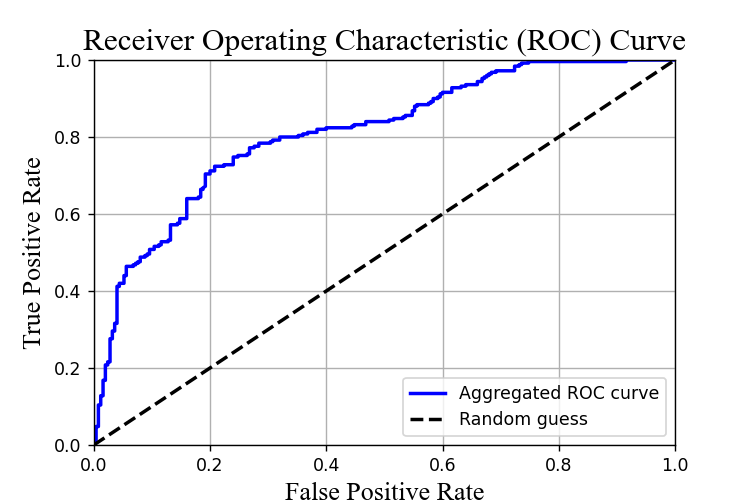

In [26]:
test_index, fpr, tpr, thresholds, auc_score = quantify_index_robustness(test_subsets, selected_features, trained_models)